# Blue Carbon Cost Tool Prototype

This notebooks prototypes the workflow for the Blue Carbon Cost tool. The tool is a excel base tool "[Blue Carbon Cost Tool - Excel full functionality (only if needed).xlsm](https://docs.google.com/spreadsheets/d/1lcmLolkwedgDrJJ54VvlMy3dn40rKjFi/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true)" that allows the user to estimate the cost of a blue carbon project. The tool has been documented in the [2305 - Blue Carbon Tool - Guidance Document_vBetaTest (1)](https://docs.google.com/document/d/1lvktavnyMVnzBpULrCF3sg5eah6xA-PS/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true).

The Blue Carbon Cost Tool has now been updated to this new version [Blue Carbon Cost Model v03 - 10-2025_share.xlsm](https://docs.google.com/spreadsheets/d/1ddbYkHgTPoke2RGsJVqqD0uyVzEmAyOs/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true) that includes the following changes:

1. Changed AGB emissions factor from 100% to 82% and included BGB in the live biomass calculation. This change originates in the 'MangroveEmissionsValues' tab of the BCCT excel workbook (fields 'Mangrove Biomass MgCha-1' and 'Mangrove AGB Emissions Factor %'). Should we consider renaming 'AGB' to 'AGB + BGB' in the tool? 
2. Updated sequestration rates. Updated to pull in sequestration for BGB. This changes some of the country-specific values for mangroves only in the 'Sequestration rate' tab. 
3. Foregone sequestration updated from Tier 1 IPCC value to country-specific value if a value exists. This changes the formula in 'Carbon potential calculations' to first look for a country-specific sequestration rate for forgone sequestration and if it doesn't exist pull in the Tier 1 sequestration rate. This change is implemented starting at the 'Annual avoided emissions' field (column EQ). 
4. Country-specific values for SOC in tidal marsh. Instead of the IPCC Tier 1 emissions for all countries, countries with data now have country-level emissions values. This change originates in the 'TidalMarshEmissionsValues' tab and is pulled into subsequent formulas on different tabs. 
5. Country-specific loss rates for tidal marsh? I'm not sure if this was already implemented but if not, there are country level loss rates for tidal marsh in the 'Ecosystem loss' tab ('salt marsh loss rate' field). 
6. Landowner/community benefit share formula change. Implemented in the 'Calculation' tab (did not update it for custom project in the excel workbook but it will need to be updated in the Vizz tool). Changes made starting at the 'Community benefit sharing fund' row (row 405). Base value is changed from 60% to 10%. The 10% is applied throughout the project regardless of profit, etc. I've used the 'other community cash flow' (starting at row 1112) bucket to implement the remainder of the 'landowner/community benefit share' formula. This should still be considered 'landowner/community benefit share' but for simplicity I did not rename from 'other community cash flow'. This is the part of the landowner/community benefit share once revenues are equal to or greater than opex. Once this occurs, 50% of the revenues are assigned to this remaining 'landowner/community benefit share' (currently called 'other community cash flow' in the tool).  Note: opex will include the 10% but will not include the 'other community cash flow' at 50% (see row 615). Note: profit (row 1069) covers opex + capex + the 'other community cash flow'.

For the current prototype we will use the "[Carbon-Cost Data Upload v02.xlsm](https://docs.google.com/spreadsheets/d/1W2KArWhR6SvmHHWK-fXb9ABFVk7jBg2q/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true)" file that has been manually simplified to only contain the data upload and the cost estimation following [this instructions](https://docs.google.com/document/d/1mGOEe_-5S0vnSG3nOJRIESVMmsF33PUEUAEykjmA-Tg/edit?usp=sharing).

## Setup

### Library import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys

import pandas as pd  # noqa: I001

sys.path.append("../src/bcc_model")

from v2.blue_carbon_project import BlueCarbonProject
from v2.breakeven_cost_calculator import BreakevenCostCalculator
from v2.cost_calculator import CostCalculator
from v2.sensitivity_analysis import plot_sensitivity_analysis
from v2.utils import generate_master_table

## Blue Carbon Cost Tool 

### Read data

In [3]:
# Import excel with the import datai
data_path = "../excel/Carbon-Cost Data Upload v02.xlsm"

**Create the master table**

To replicate the prototype we need to crete the `master_table` that the back-end team creates when the Excel is ingested. This table contains all the data contained in the `Cost` and `Carbon` tables of the Excel file.

In [ ]:
master_table = generate_master_table(data_path)
master_table.head()

**Read other tables**

In [ ]:
# Open the excel file - tab 'Base_size_table'
base_size = pd.read_excel(data_path, sheet_name="Base_size_table")

# Open the excel file - tab 'Base_increase'
base_increase = pd.read_excel(data_path, sheet_name="Base_increase")

base_size.head()

,id,activity,ecosystem,feasibility_analysis,conservation_planning_and_admin,data_collection_and_field_cost,community_representation,blue_carbon_project_planning,establishing_carbon_rights,financing_cost,validation,implementation_labor_planting,implementation_labor_hybrid,implementation_labor_hydrology,monitoring,baseline_reassessment,MRV,long_term_project_operating_cost
0,1,Restoration,Mangrove,500,2500,500,2500,500,500,500,500,0,0,0,2500,500,500,2500
1,2,Conservation,Mangrove,20000,20000,20000,20000,20000,20000,20000,20000,0,0,0,20000,20000,20000,20000
2,3,Restoration,Seagrass,500,2500,500,2500,500,500,500,500,0,0,0,2500,500,500,2500
3,4,Conservation,Seagrass,20000,20000,20000,20000,20000,20000,20000,20000,0,0,0,20000,20000,20000,20000
4,5,Restoration,Salt marsh,500,2500,500,2500,500,500,500,500,0,0,0,2500,500,500,2500


### Create example projects

In this section we will replicate the steps followed in the `Dashboard` sheet of the [`Blue Carbon Cost Tool - Excel full functionality (only if needed)`](https://docs.google.com/spreadsheets/d/1lcmLolkwedgDrJJ54VvlMy3dn40rKjFi/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true) Excel file following the `Deep dive: Excel dashboard` section in the [`Blue Carbon Tool - Guidance Document`](https://docs.google.com/document/d/1lvktavnyMVnzBpULrCF3sg5eah6xA-PS/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true).

**(1) Input - Project parameters**

This section outlines the standard project parameters for a hypothetical blue carbon project. Users have the flexibility to adjust these parameters according to their preferences or specific requirements.

In [ ]:
# EXAMPLE 1
project_name = "Restoration_Mangrove_Indonesia"
# Example usage for a restoration project
project = BlueCarbonProject(
    project_size_ha=1000,
    activity="Restoration",
    ecosystem="Mangrove",
    country="Indonesia",
    master_table=master_table,
    base_size=base_size,
    base_increase=base_increase,
    carbon_price=30,  # Default value 30
    carbon_revenues_to_cover="capex+Opex",  # ['Opex', 'capex+Opex']
    restoration_activity="Planting",  # ['Planting', 'Hybrid', 'Hydrology']
    sequestration_rate_used="Tier 2 - Country-specific rate",  # ['Tier 1 - IPCC default value',
    #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
    project_specific_sequestration_rate=None,
    planting_success_rate=0.6,  # Default value 0.8
    # loss_rate_used="National average",  # ['National average', 'project-specific']
    # project_specific_loss_rate=-0.1, # -0.10% loss rate
    # emission_factor_used="Tier 2 - Country-specific emission factor",
    # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
    #  'Tier 3 - Project specific emission factor']
    # tier_3_project_specific_emission="AGB and SOC separately",
    # ['One emission factor', 'AGB and SOC separately']
    # tier_3_project_specific_emission_one_factor=0.5,
    # tier_3_emission_factor_AGB=0.5,
    # tier_3_emission_factor_SOC=0.5
)

In [8]:
# EXAMPLE 2
project_name = "Conservation_Mangrove_Indonesia"
# Example usage for a conservation project
project = BlueCarbonProject(
    activity="Conservation",  # ['Restoration', 'Conservation']
    ecosystem="Mangrove",  #  ['Mangrove', 'Seagrass', 'Salt marsh']
    country="Indonesia",
    master_table=master_table,
    base_size=base_size,
    base_increase=base_increase,
    carbon_price=20,  # Default value 30
    carbon_revenues_to_cover="Opex",  # ['Opex', 'capex+Opex']
    project_size_ha=10000,
    # restoration_activity='Planting', # ['Planting', 'Hybrid', 'Hydrology']
    # sequestration_rate_used='Tier 1 - IPCC default value', # ['Tier 1 - IPCC default value',
    #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
    # project_specific_sequestration_rate=None,
    # planting_success_rate=0.8, # Default value 0.8
    loss_rate_used="project-specific",  # ['National average', 'project-specific']
    project_specific_loss_rate=-0.001,  # -0.10% loss rate
    emission_factor_used="Tier 2 - Country-specific emission factor",
    # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
    #  'Tier 3 - Project specific emission factor']
    # tier_3_project_specific_emission="AGB and SOC separately",
    # ['One emission factor', 'AGB and SOC separately']
    # tier_3_project_specific_emission_one_factor=0.5,
    # tier_3_emission_factor_AGB=0.5,
    # tier_3_emission_factor_SOC=0.5
)

In [9]:
### EXAMPLE 3
project_name = "Restoration_China_Salt_marsh"
# Example usage for a restoration project
project = BlueCarbonProject(
    activity="Restoration",  # ['Restoration', 'Conservation']
    ecosystem="Salt marsh",  #  ['Mangrove', 'Seagrass', 'Salt marsh']
    country="China",  # [
    #'United States', 'Indonesia', 'Australia', 'The Bahamas', 'Kenya', 'Mexico',
    # 'Colombia', 'India', 'China']
    master_table=master_table,
    base_size=base_size,
    base_increase=base_increase,
    carbon_price=30,  # Default value 30
    carbon_revenues_to_cover="Opex",  # ['Opex', 'capex+Opex']
    project_size_ha=500,
    restoration_activity="Hydrology",  # ['Planting', 'Hybrid', 'Hydrology']
    sequestration_rate_used="Tier 1 - IPCC default value",  # ['Tier 1 - IPCC default value',
    #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
    # project_specific_sequestration_rate=None,
    planting_success_rate=0.8,  # Default value 0.8
    # loss_rate_used="project-specific",  # ['National average', 'project-specific']
    # project_specific_loss_rate=-0.001, # -0.10% loss rate
    # emission_factor_used="Tier 2 - Country-specific emission factor",
    # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
    #  'Tier 3 - Project specific emission factor']
    # tier_3_project_specific_emission="AGB and SOC separately",
    # ['One emission factor', 'AGB and SOC separately']
    # tier_3_project_specific_emission_one_factor=0.5,
    # tier_3_emission_factor_AGB=0.5,
    # tier_3_emission_factor_SOC=0.5
)

**(2) Input - Model assumptions** 

Users can modify model assumptions by overriding the standard base values for conducting bespoke project analysis.

In [10]:
# project.set_additional_assumptions(
#    # verification_frequency,
#    discount_rate=1.3,
#    # carbon_price_increase,
#    buffer=0.28,
#    # baseline_reassessment_frequency,
#    conservation_project_length=30,
#    # restoration_project_length,
#    # restoration_rate
# )

**(3) Input - Cost components**

The model always displays these standard costs, but users have the option to override them for customized project analysis.


In [11]:
# project.override_cost_input(
#    feasibility_analysis=30000
#    # conservation_planning_and_admin,
#    # data_collection_and_field_cost,
#    # community_representation,
#    # blue_carbon_project_planning,
#    # establishing_carbon_rights,
#    # validation,
#    # implementation_labor,
#    # monitoring,
#    # maintenance,
#    # community_benefit_sharing_fund,
#    # carbon_standard_fees,
#    # baseline_reassessment,
#    # MRV,
#    # long_term_project_operating,
#    # financing_cost
# )

**(4) Input – Restoration plan** 

Used for restoration projects only. Users can use this section to have more control over the restoration plan input.
To have greater control over the timeline of the restoration plan, kindly provide the annual hectares restored in the blue space provided. Ensure that the cumulative sum does not exceed your original project size and remains within your designated project timeline. The restoration plan is calculated automatically base on the restoration project size (ha) and the restoration rate (ha/year). The restoration plan is calculated as follows:
```python
def _initialize_restoration_plan(self):
    restoration_plan = {}
    # Baseline restoration value
    if self.project_size_ha > self.restoration_rate:
        restoration_plan[-1] = self.restoration_rate
    else:
        restoration_plan[-1] = self.project_size_ha
    # Initialize remaining hectares to be restored
    remaining = self.project_size_ha
    # Years run from -1 to the restoration project length
    for year in range(-1, self.restoration_project_length + 1):
        if remaining > 0:
            if remaining >= self.restoration_rate:
                restoration_plan[year] = self.restoration_rate
                remaining -= self.restoration_rate
            else:
                restoration_plan[year] = remaining
                remaining = 0
        else:
            restoration_plan[year] = 0
    return restoration_plan
```
The restoration plan is generated by adding the restoration_rate each year until the cumulative restored area meets the project size. 

The user can also manually override the restoration plan by entering the hectares restored each year. The model will then use this custom restoration plan instead of the default one. You can override the restoration plan as follows:

In [ ]:
#restoration_plan = {}
#restoration_plan[-1] = 500
#restoration_plan.update(dict.fromkeys(range(1, 31), 0))
#restoration_plan[1] = 500
#cumulative_size = sum(restoration_plan.values())
#if cumulative_size <= project.project_size_ha:
#    project.update_restoration_plan(restoration_plan)


**Check all input parameters**

In [ ]:
project_parameters = project.get_project_parameters()

### Project Parameters
| Parameter                                      | Value                                   |
| ---------------------------------------------- | --------------------------------------- |
| Project size (ha) | 1000 |
| Initial carbon price assumption ($) | 30 |
| Country | Indonesia |
| Ecosystem | Mangrove |
| Activity | Restoration |
| Carbon revenues to cover | capex+Opex |
| Carbon revenues will not cover | None |
**Additional parameters for a Restoration project**
| Activity type - Restoration | Planting |
| Sequestration rate used | Tier 2 - Country-specific rate |
| Tier 2 - Country-specific rate | 64.51 |
| Project-specific sequestration rate (tCO2e/ha/yr) | None |
| Planting Success Rate (%) | 60.0 |
### Assumptions
| Parameter                                      | Value                                   |
| ---------------------------------------------- | --------------------------------------- |
| Verification frequency (yr) | 5 |
| Discount rate (%) | 4.0 |
| Carbon price increase (%) | 1.5 |
| Buffer (%) | 20 |
| Baseline reassessment frequency (yr) | 10 |
**Additional assumptions for a Restoration project**
| Restoration rate (ha/yr) | 250 |
| Restoration project length (yr) | 20 |
### Cost Inputs
| Parameter                                      | Value                                   |
| ---------------------------------------------- | --------------------------------------- |
| **CAPEX**                                      |                                         |
| Feasibility_analysis ($/project) | 50,000 |
| Conservation planning and admin ($/yr) | 166,767 |
| Data collection and field cost ($/yr) | 26,667 |
| Community representation ($/yr) | 71,183 |
| Blue carbon project planning ($/project) | 100,000 |
| Establishing carbon rights ($/yr) | 46,667 |
| Validation ($/project) | 50,000 |
| Implementation labor ($/ha) | 2,000 |
| **OPEX**                                       |                                         |
| Monitoring ($/yr) | 15,000 |
| Maintenance (% of implementation labor) | 8 |
| Community benefit sharing fund (% of revenue) | 50 |
| Carbon standard fees ($/credit) | 0.20 |
| Baseline reassessment ($/event) | 40,000 |
| MRV ($/event) | 75,000 |
| Long-term project operating ($/yr) | 26,400 |
| **Other**                                       |                                         |
| Financing cost (% of capex) | 5 |
### Restoration Plan
| Year                                           | Annual ha                               |
| ---------------------------------------------- | --------------------------------------- |
| -1 | 500 |
| 1 | 500 |
| 2 | 0 |
| 3 | 0 |
| 4 | 0 |
| 5 | 0 |
| 6 | 0 |
| 7 | 0 |
| 8 | 0 |
| 9 | 0 |
| 10 | 0 |
| 11 | 0 |
| 12 | 0 |
| 13 | 0 |
| 14 | 0 |
| 15 | 0 |
| 16 | 0 |
| 17 | 0 |
| 18 | 0 |
| 19 | 0 |
| 20 | 0 |

### Calculate costs

In [ ]:
cost_calculator = CostCalculator(project)

**(5) Output - Project summary** 

This table provides a concise summary “snapshot” of the key economic outcomes for the hypothetical blue carbon project. 

In [ ]:
cost_summary = cost_calculator.get_summary()

### Project Summary
| Parameter                            | Value                                             |
| ------------------------------------ | ------------------------------------------------- |
| Project | Indonesia Mangrove Restoration (1000 ha) |
| $/tCO2e (total cost, NPV) | $18 |
| $/ha | $17,642 |
| NPV covering cost | $1,930,574 |
| IRR when priced to cover opex | 358.5% |
| IRR when priced to cover total costs | 8.9% |
| Total cost (NPV) | $10,585,446 |
| Capital expenditure (NPV) | $3,108,862 |
| Operating expenditure (NPV) | $7,476,583 |
| Credits issued | 603,814 |
| Total revenue (NPV) | $12,516,020 |
| Total revenue (non-discounted) | $21,331,362 |
| Financing cost | $172,590 |
| Funding gap (NPV) | $0 |
| Funding gap per tCO2e (NPV) | $0.0 |
| Community benefit sharing fund % of revenue | 50% |

**(6) Output - Detailed cost summary**

This table shows a comprehensive breakdown of each cost component for the hypothetical blue carbon project. 

In [ ]:
cost_estimates = cost_calculator.get_cost_estimates()

### Cost Estimates
| Cost estimates (USD)   | Total cost      | NPV             |
| ---------------------- | --------------- | --------------- |
| **Capital expenditure** | **$3,451,800** | **$3,108,862** |
| Feasibility analysis | $50,000 | $50,000 |
| Conservation planning and admin | $667,067 | $629,559 |
| Data collection and field costs | $160,000 | $153,925 |
| Community representation / liaison | $284,733 | $268,724 |
| Blue carbon project planning | $100,000 | $88,900 |
| Establishing carbon rights | $140,000 | $129,504 |
| Validation | $50,000 | $44,450 |
| Implementation labor | $2,000,000 | $1,743,801 |
| **Operating expenditure** | **$12,534,244** | **$7,476,583** |
| Monitoring | $300,000 | $181,226 |
| Maintenance | $499,800 | $403,106 |
| Community benefit sharing fund | $10,665,681 | $6,258,010 |
| Carbon standard fees | $120,763 | $72,175 |
| Baseline reassessment | $120,000 | $75,812 |
| MRV | $300,000 | $167,296 |
| Long-term project operating | $528,000 | $318,958 |
| **Total cost** | **$15,986,044** | **$10,585,446** |

**(7) Output - Sensitivity analysis**

This section presents a sensitivity analysis, illustrating the relative impact of changes to cost components on the hypothetical blue carbon project. 

Sensitivity analysis results exported to sensitivity_analysis_results.csv


## Sensitivity Analysis (±25%)

,Cost Input,Min % Change,Max % Change,Base params,Base Cost per tCO2e,Min Cost per tCO2e,Max Cost per tCO2e
0,feasibility_analysis,-0.123689,0.123536,50000.000000,17.641669,17.619848,17.663490
1,conservation_planning_and_admin,-1.557389,1.533506,166766.666667,17.641669,17.366920,17.916418
2,data_collection_and_field_cost,-0.380776,0.379332,26666.666667,17.641669,17.574494,17.708844
3,community_representation,-0.664762,0.660372,71183.333333,17.641669,17.524394,17.758944
4,blue_carbon_project_planning,-0.219918,0.219435,100000.000000,17.641669,17.602872,17.680466
5,establishing_carbon_rights,-0.320364,0.319341,46666.666667,17.641669,17.585151,17.698187
6,financing_cost,-0.000000,0.000000,0.050000,17.641669,17.641669,17.641669
7,validation,-0.109959,0.109838,50000.000000,17.641669,17.622271,17.661068
8,implementation_labor,-5.110625,4.862140,2000.000000,17.641669,16.740069,18.543269
9,monitoring,-0.448313,0.446312,15000.000000,17.641669,17.562579,17.720759


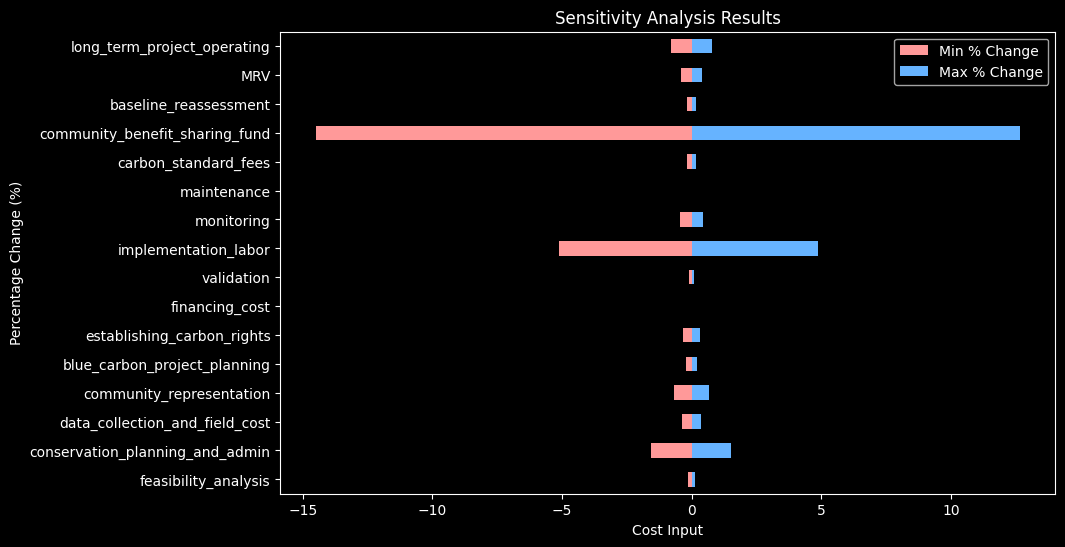

In [10]:
plot_sensitivity_analysis(project, CostCalculator, True)

**(8) Output - Projected cash flow** 

This section shows the projected cash flow timing for the hypothetical blue carbon project. 

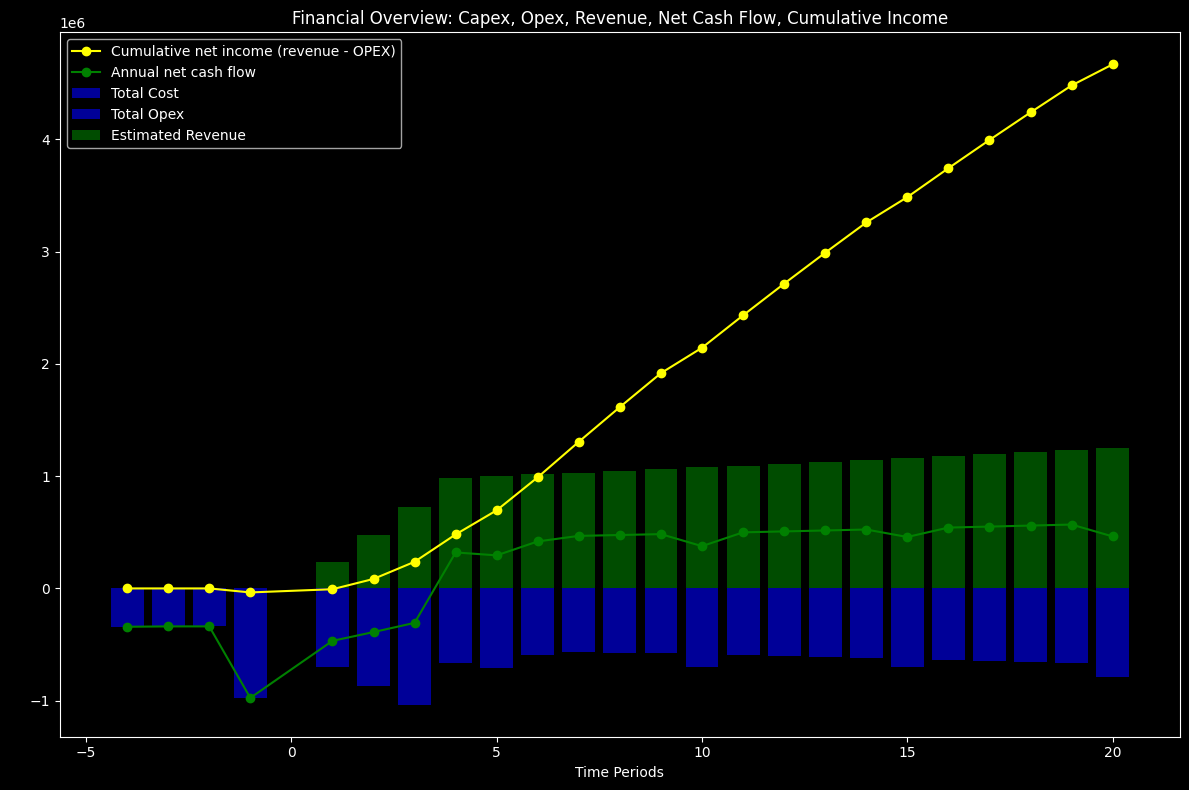

In [11]:
cost_graph = cost_calculator.plot_financial_data()
cost_graph

**“Pro Forma” sheet**

This section presents the yearly cash flows associated with the hypothetical blue carbon project.

In [14]:
yearly_cost_breakdown = cost_calculator.get_yearly_cost_breakdown()

### Pro Forma Financials
| Year | -4 | -3 | -2 | -1 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | Total | NPV |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Feasibility analysis | -50000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -50000.0 | -50000.0 |
| Conservation planning and admin | -166767.0 | -166767.0 | -166767.0 | -166767.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -667067.0 | -629559.0 |
| Data collection and field costs | -53333.0 | -53333.0 | -53333.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -160000.0 | -153925.0 |
| Community representation / liaison | -71183.0 | -71183.0 | -71183.0 | -71183.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -284733.0 | -268724.0 |
| Blue carbon project planning | 0 | 0 | 0 | -100000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -100000.0 | -88900.0 |
| Establishing carbon rights | 0 | -46667.0 | -46667.0 | -46667.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -140000.0 | -129504.0 |
| Validation | 0 | 0 | 0 | -50000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -50000.0 | -44450.0 |
| Implementation labor | 0 | 0 | 0 | -500000.0 | -500000.0 | -500000.0 | -500000.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -2000000.0 | -1678021.0 |
| **Total capex** | **-341283.0** | **-337950.0** | **-337950.0** | **-934617.0** | **-500000.0** | **-500000.0** | **-500000.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-3451800.0** | **-3043083.0** |
| Monitoring | 0 | 0 | 0 | 0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -300000.0 | -181226.0 |
| Maintenance | 0 | 0 | 0 | 0 | -40000.0 | -80000.0 | -120000.0 | -120000.0 | -80000.0 | -40000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -480000.0 | -372533.0 |
| Community benefit sharing fund | -0.0 | -0.0 | -0.0 | -0.0 | -117860.0 | -239255.0 | -364266.0 | -492974.0 | -500368.0 | -507874.0 | -515492.0 | -523224.0 | -531073.0 | -539039.0 | -547124.0 | -555331.0 | -563661.0 | -572116.0 | -580698.0 | -589408.0 | -598249.0 | -607223.0 | -616331.0 | -625576.0 | -10187144.0 | -5864651.0 |
| Carbon standard fees | 0 | 0 | 0 | 0 | -1548.0 | -3096.0 | -4645.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -6193.0 | -114570.0 | -67083.0 |
| Baseline reassessment | 0 | 0 | 0 | -40000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -40000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -40000.0 | -120000.0 | -75812.0 |
| MRV | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -75000.0 | 0 | 0 | 0 | 0 | -75000.0 | 0 | 0 | 0 | 0 | -75000.0 | 0 | 0 | 0 | 0 | -75000.0 | -300000.0 | -167296.0 |
| Long-term project operating | 0 | 0 | 0 | 0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -660000.0 | -398698.0 |
| **Total opex** | **-0.0** | **-0.0** | **-0.0** | **-40000.0** | **-200808.0** | **-363752.0** | **-530311.0** | **-660567.0** | **-702961.0** | **-595467.0** | **-563085.0** | **-570817.0** | **-578666.0** | **-701632.0** | **-594717.0** | **-602924.0** | **-611254.0** | **-619709.0** | **-703291.0** | **-637001.0** | **-645842.0** | **-654816.0** | **-663924.0** | **-788169.0** | **-12029713.0** | **-7047559.0** |
| **Total cost** | **-341283.0** | **-337950.0** | **-337950.0** | **-974617.0** | **-700808.0** | **-863752.0** | **-1030311.0** | **-660567.0** | **-702961.0** | **-595467.0** | **-563085.0** | **-570817.0** | **-578666.0** | **-701632.0** | **-594717.0** | **-602924.0** | **-611254.0** | **-619709.0** | **-703291.0** | **-637001.0** | **-645842.0** | **-654816.0** | **-663924.0** | **-788169.0** | **-15481513.0** | **-10090642.0** |
| Est. credits issued | 0 | 0 | 0 | 0.0 | 7741.2 | 15482.4 | 23223.6 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 30964.8 | 572848.8 | 0 |
| **Est. revenue** | **0** | **0** | **0** | **0.0** | **235720.0** | **478511.0** | **728532.0** | **985947.0** | **1000737.0** | **1015748.0** | **1030984.0** | **1046449.0** | **1062145.0** | **1078077.0** | **1094249.0** | **1110662.0** | **1127322.0** | **1144232.0** | **1161396.0** | **1178817.0** | **1196499.0** | **1214446.0** | **1232663.0** | **1251153.0** | **20374287.0** | **11729302.0** |
| Annual net cash flow | -341283.0 | -337950.0 | -337950.0 | -974617.0 | -465088.0 | -385241.0 | -301778.0 | 325381.0 | 297775.0 | 420281.0 | 467899.0 | 475631.0 | 483480.0 | 376446.0 | 499531.0 | 507738.0 | 516068.0 | 524523.0 | 458105.0 | 541815.0 | 550656.0 | 559630.0 | 568739.0 | 462983.0 | 4892774.0 | 1638660.0 |
| Annual net income (revenue – OPEX) | 0.0 | 0.0 | 0.0 | -40000.0 | 34912.0 | 114759.0 | 198222.0 | 325381.0 | 297775.0 | 420281.0 | 467899.0 | 475631.0 | 483480.0 | 376446.0 | 499531.0 | 507738.0 | 516068.0 | 524523.0 | 458105.0 | 541815.0 | 550656.0 | 559630.0 | 568739.0 | 462983.0 | 8344574.0 | 4681742.0 |
| Cumulative net income (revenue - OPEX) | 0.0 | 0.0 | 0.0 | -35560.0 | -5717.0 | 88606.0 | 245263.0 | 492526.0 | 710108.0 | 1005391.0 | 1321487.0 | 1630448.0 | 1932428.0 | 2158512.0 | 2446978.0 | 2728907.0 | 3004440.0 | 3273717.0 | 3499850.0 | 3757019.0 | 4008331.0 | 4253915.0 | 4493898.0 | 4681742.0 | 0 | 0 |
| Cumulative net income (revenue - CAPEX - OPEX) | -341283.0 | -666235.0 | -978689.0 | -1845120.0 | -2242679.0 | -2559319.0 | -2797819.0 | -2550557.0 | -2332975.0 | -2037692.0 | -1721596.0 | -1412635.0 | -1110655.0 | -884571.0 | -596104.0 | -314175.0 | -38642.0 | 230634.0 | 456767.0 | 713936.0 | 965248.0 | 1210833.0 | 1450815.0 | 1638660.0 | 0 | 0 |

In [20]:
# Export to test_data to compare calculated results with expected ones
# yearly_cost_breakdown.to_csv("./test_data/Pro_forma_calculated_data.csv", index=False)

### Calculate breakeven price

Calculate carbon price to obtain NPV covering cost to zero.

In [21]:
# Calculate the breakeven cost
breakeven_cost_calculator = BreakevenCostCalculator(project)
breakeven_cost = breakeven_cost_calculator.calculate_breakeven_cost()
print(f"The breakeven cost is: {breakeven_cost['breakeven_carbon_price']}")

Iteration 0: NPV covering cost = -25111784.9721516,
            Carbon price = 30
Iteration 1: NPV covering cost = -16436381.476541974,
            Carbon price = 994.8730104373676
Iteration 2: NPV covering cost = -10758081.766867932,
            Carbon price = 1626.4099917214671
Iteration 3: NPV covering cost = -7041472.204073332,
            Carbon price = 2039.769008312307
Iteration 4: NPV covering cost = -4608844.947938375,
            Carbon price = 2310.3243069893947
Iteration 5: NPV covering cost = -3016620.834184304,
            Carbon price = 2487.4104880190553
Iteration 6: NPV covering cost = -1974464.6131576672,
            Carbon price = 2603.3184582750664
Iteration 7: NPV covering cost = -1292343.5601962209,
            Carbon price = 2679.1835398458193
Iteration 8: NPV covering cost = -845875.8219574392,
            Carbon price = 2728.839405521187
Iteration 9: NPV covering cost = -553649.9180322662,
            Carbon price = 2761.340589793566
Iteration 10: NPV covering 

### Export outputs as `JSON` file

In [22]:
if project.activity == "Restoration":
    output = {
        "initialCarbonPriceComputationOutput": {
            "sequestrationRate": project_parameters["Project parameters"][
                "For Restoration Projects Only"
            ][project.sequestration_rate_used],
            "plantingSuccessRate": 0.8,
            "carbonRevenuesToCover": project_parameters["Project parameters"][
                "Carbon revenues to cover"
            ],
            "initialCarbonPrice": project_parameters["Project parameters"][
                "Initial carbon price assumption ($)"
            ],
        },
        "breakevenPriceComputationOutput": {
            "carbonRevenuesToCover": breakeven_cost["project_params"]["Project parameters"][
                "Carbon revenues to cover"
            ],
            "sequestrationRate": project_parameters["Project parameters"][
                "For Restoration Projects Only"
            ][project.sequestration_rate_used],
            "plantingSuccessRate": 0.8,
            "initialCarbonPrice": float(
                breakeven_cost["project_params"]["Project parameters"][
                    "Initial carbon price assumption ($)"
                ]
            ),
        },
    }
else:
    output = {
        "initialCarbonPriceComputationOutput": {
            "lossRate": project_parameters["Project parameters"]["For Conservation Projects Only"][
                "project-specific"
            ],
            "carbonRevenuesToCover": project_parameters["Project parameters"][
                "Carbon revenues to cover"
            ],
            "initialCarbonPrice": project_parameters["Project parameters"][
                "Initial carbon price assumption ($)"
            ],
            "emissionFactors": {
                "emissionFactor": None,
                "emissionFactorAgb": project_parameters["Project parameters"][
                    "For Conservation Projects Only"
                ]["Country-specific emission factors"]["Emission factor AGB"],  # noqa: E501
                "emissionFactorSoc": project_parameters["Project parameters"][
                    "For Conservation Projects Only"
                ]["Country-specific emission factors"]["Emission factor SOC"],  # noqa: E501
            },
        },
        "breakevenPriceComputationOutput": {
            # Update values as first element of the list
            "lossRate": breakeven_cost["project_params"]["Project parameters"][
                "For Conservation Projects Only"
            ]["project-specific"],  # noqa: E501
            "carbonRevenuesToCover": breakeven_cost["project_params"]["Project parameters"][
                "Carbon revenues to cover"
            ],
            "initialCarbonPrice": float(
                breakeven_cost["project_params"]["Project parameters"][
                    "Initial carbon price assumption ($)"
                ]
            ),
            "emissionFactors": {
                "emissionFactor": None,
                "emissionFactorAgb": breakeven_cost["project_params"]["Project parameters"][
                    "For Conservation Projects Only"
                ]["Country-specific emission factors"]["Emission factor AGB"],  # noqa: E501
                "emissionFactorSoc": breakeven_cost["project_params"]["Project parameters"][
                    "For Conservation Projects Only"
                ]["Country-specific emission factors"]["Emission factor SOC"],  # noqa: E501
            },
        },
    }

initial_carbon_price_computation_output = {
    "totalProjectCost": {
        "total": {
            "total": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "capex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Capital expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "total": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "capex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Capital expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "leftover": {
        # review when is OPEX + CAPEX
        "total": {
            "total": int(
                cost_summary["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "leftover": int(
                cost_summary["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if project_parameters["Project parameters"]["Carbon revenues to cover"] == "Opex"
            else int(
                cost_summary["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if project_parameters["Project parameters"]["Carbon revenues to cover"] == "Opex"
            else int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "total": int(
                cost_summary["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "leftover": int(
                cost_summary["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if project_parameters["Project parameters"]["Carbon revenues to cover"] == "Opex"
            else int(
                cost_summary["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if project_parameters["Project parameters"]["Carbon revenues to cover"] == "Opex"
            else int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "summary": {
        "$/tCO2e (total cost, NPV)": int(
            cost_summary["Project summary"]["$/tCO2e (total cost, NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "$/ha": int(cost_summary["Project summary"]["$/ha"].replace("$", "").replace(",", "")),
        "NPV covering cost": int(
            cost_summary["Project summary"]["NPV covering cost"].replace("$", "").replace(",", "")
        ),
        # double check this attribute - this value should be the same as the NPV covering cost so how is it used?  # noqa: E501
        "Leftover after OpEx / total cost": int(
            cost_summary["Project summary"]["NPV covering cost"].replace("$", "").replace(",", "")
        ),
        "IRR when priced to cover OpEx": float(
            cost_summary["Project summary"]["IRR when priced to cover opex"].replace("%", "")
        )
        / 100,
        "IRR when priced to cover total cost": float(
            cost_summary["Project summary"]["IRR when priced to cover total costs"].replace("%", "")
        )
        / 100,
        "Total cost (NPV)": int(
            cost_summary["Project summary"]["Total cost (NPV)"].replace("$", "").replace(",", "")
        ),
        "Capital expenditure (NPV)": int(
            cost_summary["Project summary"]["Capital expenditure (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Operating expenditure (NPV)": int(
            cost_summary["Project summary"]["Operating expenditure (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Credits issued": int(cost_summary["Project summary"]["Credits issued"].replace(",", "")),
        "Total revenue (NPV)": int(
            cost_summary["Project summary"]["Total revenue (NPV)"].replace("$", "").replace(",", "")
        ),
        "Total revenue (non-discounted)": int(
            cost_summary["Project summary"]["Total revenue (non-discounted)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Financing cost": int(
            cost_summary["Project summary"]["Financing cost"].replace("$", "").replace(",", "")
        ),
        # dueble check - we should remove this and just show the fundin gap (NPV)
        "Funding gap": int(
            cost_summary["Project summary"]["Funding gap (NPV)"].replace("$", "").replace(",", "")
        ),
        "Funding gap (NPV)": int(
            cost_summary["Project summary"]["Funding gap (NPV)"].replace("$", "").replace(",", "")
        ),
        "Funding gap per tCO2e (NPV)": float(
            cost_summary["Project summary"]["Funding gap per tCO2e (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Community benefit sharing fund": int(
            cost_summary["Project summary"]["Community benefit sharing fund % of revenue"]
            .replace("%", "")
            .replace(",", "")
        )
        / 100,
    },
    "costDetails": {
        "total": {
            "capitalExpenditure": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Capital expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "operationalExpenditure": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "totalCost": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "feasibilityAnalysis": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Feasibility analysis",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "conservationPlanningAndAdmin": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Conservation planning and admin",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "dataCollectionAndFieldCost": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Data collection and field costs",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityRepresentation": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Community representation / liaison",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "blueCarbonProjectPlanning": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Blue carbon project planning",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "establishingCarbonRights": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Establishing carbon rights",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "validation": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Validation", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "implementationLabor": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Implementation labor",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "monitoring": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Monitoring", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "maintenance": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Maintenance", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityBenefitSharingFund": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Community benefit sharing fund",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "carbonStandardFees": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Carbon standard fees",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "baselineReassessment": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Baseline reassessment",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "mrv": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "MRV", "Total cost"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "longTermProjectOperatingCost": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Long-term project operating",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "capitalExpenditure": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Capital expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "operationalExpenditure": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "totalCost": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "feasibilityAnalysis": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Feasibility analysis", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "conservationPlanningAndAdmin": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Conservation planning and admin",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "dataCollectionAndFieldCost": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Data collection and field costs",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityRepresentation": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Community representation / liaison",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "blueCarbonProjectPlanning": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Blue carbon project planning",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "establishingCarbonRights": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Establishing carbon rights",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "validation": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Validation", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "implementationLabor": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Implementation labor", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "monitoring": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Monitoring", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "maintenance": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Maintenance", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityBenefitSharingFund": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Community benefit sharing fund",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "carbonStandardFees": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Carbon standard fees", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "baselineReassessment": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Baseline reassessment", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "mrv": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "MRV", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "longTermProjectOperatingCost": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Long-term project operating",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "yearlyBreakdown": [
        {
            "costName": "feasibilityAnalysis",
            "totalCost": float(yearly_cost_breakdown.loc["Feasibility analysis"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Feasibility analysis"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Feasibility analysis"][:-2].items()),
        },
        {
            "costName": "conservationPlanningAndAdmin",
            "totalCost": float(
                yearly_cost_breakdown.loc["Conservation planning and admin"]["Total"]
            ),
            "totalNPV": float(yearly_cost_breakdown.loc["Conservation planning and admin"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Conservation planning and admin"][:-2].items()
            ),
        },
        {
            "costName": "dataCollectionAndFieldCost",
            "totalCost": float(
                yearly_cost_breakdown.loc["Data collection and field costs"]["Total"]
            ),
            "totalNPV": float(yearly_cost_breakdown.loc["Data collection and field costs"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Data collection and field costs"][:-2].items()
            ),
        },
        {
            "costName": "blueCarbonProjectPlanning",
            "totalCost": float(yearly_cost_breakdown.loc["Blue carbon project planning"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Blue carbon project planning"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Blue carbon project planning"][:-2].items()
            ),
        },
        {
            "costName": "communityRepresentation",
            "totalCost": float(
                yearly_cost_breakdown.loc["Community representation / liaison"]["Total"]
            ),
            "totalNPV": float(
                yearly_cost_breakdown.loc["Community representation / liaison"]["NPV"]
            ),
            "costValues": dict(
                yearly_cost_breakdown.loc["Community representation / liaison"][:-2].items()
            ),
        },
        {
            "costName": "establishingCarbonRights",
            "totalCost": float(yearly_cost_breakdown.loc["Establishing carbon rights"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Establishing carbon rights"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Establishing carbon rights"][:-2].items()
            ),
        },
        {
            "costName": "validation",
            "totalCost": float(yearly_cost_breakdown.loc["Validation"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Validation"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Validation"][:-2].items()),
        },
        {
            "costName": "implementationLabor",
            "totalCost": float(yearly_cost_breakdown.loc["Implementation labor"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Implementation labor"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Implementation labor"][:-2].items()),
        },
        {
            "costName": "monitoring",
            "totalCost": float(yearly_cost_breakdown.loc["Monitoring"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Monitoring"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Monitoring"][:-2].items()),
        },
        {
            "costName": "maintenance",
            "totalCost": float(yearly_cost_breakdown.loc["Maintenance"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Maintenance"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Maintenance"][:-2].items()),
        },
        {
            "costName": "communityBenefitSharingFund",
            "totalCost": float(
                yearly_cost_breakdown.loc["Community benefit sharing fund"]["Total"]
            ),
            "totalNPV": float(yearly_cost_breakdown.loc["Community benefit sharing fund"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Community benefit sharing fund"][:-2].items()
            ),
        },
        {
            "costName": "carbonStandardFees",
            "totalCost": float(yearly_cost_breakdown.loc["Carbon standard fees"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Carbon standard fees"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Carbon standard fees"][:-2].items()),
        },
        {
            "costName": "baselineReassessment",
            "totalCost": float(yearly_cost_breakdown.loc["Baseline reassessment"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Baseline reassessment"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Baseline reassessment"][:-2].items()),
        },
        {
            "costName": "mrv",
            "totalCost": float(yearly_cost_breakdown.loc["MRV"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["MRV"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["MRV"][:-2].items()),
        },
        {
            "costName": "longTermProjectOperatingCost",
            "totalCost": float(yearly_cost_breakdown.loc["Long-term project operating"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Long-term project operating"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Long-term project operating"][:-2].items()
            ),
        },
        {
            "costName": "opexTotalCostPlan",
            "totalCost": float(yearly_cost_breakdown.loc["Total opex"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Total opex"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Total opex"][:-2].items()),
        },
        {
            "costName": "capexTotalCostPlan",
            "totalCost": float(yearly_cost_breakdown.loc["Total capex"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Total capex"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Total capex"][:-2].items()),
        },
        {
            "costName": "totalCostPlan",
            "totalCost": float(yearly_cost_breakdown.loc["Total cost"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Total cost"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Total cost"][:-2].items()),
        },
        {
            "costName": "estimatedRevenuePlan",
            "totalCost": float(yearly_cost_breakdown.loc["Est. revenue"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Est. revenue"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Est. revenue"][:-2].items()),
        },
        {
            "costName": "creditsIssuedPlan",
            "totalCost": float(yearly_cost_breakdown.loc["Est. credits issued"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Est. credits issued"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Est. credits issued"][:-2].items()),
        },
        {
            "costName": "cumulativeNetIncomePlan",
            "totalCost": float(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - OPEX)"]["Total"]
            ),
            "totalNPV": float(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - OPEX)"]["NPV"]
            ),
            "costValues": dict(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - OPEX)"][:-2].items()
            ),
        },
        {
            "costName": "cumulativeNetIncomeCapexOpex",
            "totalCost": float(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - CAPEX - OPEX)"]["Total"]
            ),
            "totalNPV": float(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - CAPEX - OPEX)"]["NPV"]
            ),
            "costValues": dict(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - CAPEX - OPEX)"][
                    :-2
                ].items()
            ),
        },
        {
            "costName": "annualNetCashFlow",
            "totalCost": float(yearly_cost_breakdown.loc["Annual net cash flow"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Annual net cash flow"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Annual net cash flow"][:-2].items()),
        },
        {
            "costName": "annualNetIncome",
            "totalCost": float(
                yearly_cost_breakdown.loc["Annual net income (revenue – OPEX)"]["Total"]
            ),
            "totalNPV": float(
                yearly_cost_breakdown.loc["Annual net income (revenue – OPEX)"]["NPV"]
            ),
            "costValues": dict(
                yearly_cost_breakdown.loc["Annual net income (revenue – OPEX)"][:-2].items()
            ),
        },
    ],
}
breakeven_carbon_price_computation_output = {
    "totalProjectCost": {
        "total": {
            "total": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "capex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Capital expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "total": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "capex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Capital expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "leftover": {
        "total": {
            "total": int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "leftover": int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if breakeven_cost["project_params"]["Project parameters"]["Carbon revenues to cover"]
            == "Opex"
            else int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if breakeven_cost["project_params"]["Project parameters"]["Carbon revenues to cover"]
            == "Opex"
            else int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "total": int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "leftover": int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if breakeven_cost["project_params"]["Project parameters"]["Carbon revenues to cover"]
            == "Opex"
            else int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if breakeven_cost["project_params"]["Project parameters"]["Carbon revenues to cover"]
            == "Opex"
            else int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "summary": {
        "$/tCO2e (total cost, NPV)": int(
            breakeven_cost["cost_summary"]["Project summary"]["$/tCO2e (total cost, NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "$/ha": int(
            breakeven_cost["cost_summary"]["Project summary"]["$/ha"]
            .replace("$", "")
            .replace(",", "")
        ),
        "NPV covering cost": int(
            breakeven_cost["cost_summary"]["Project summary"]["NPV covering cost"]
            .replace("$", "")
            .replace(",", "")
        ),
        # double check this attribute - this value should be the same as the NPV covering cost so how is it used?  # noqa: E501
        "Leftover after OpEx / total cost": int(
            breakeven_cost["cost_summary"]["Project summary"]["NPV covering cost"]
            .replace("$", "")
            .replace(",", "")
        ),
        "IRR when priced to cover OpEx": float(
            breakeven_cost["cost_summary"]["Project summary"][
                "IRR when priced to cover opex"
            ].replace("%", "")
        )
        / 100,
        "IRR when priced to cover total cost": float(
            breakeven_cost["cost_summary"]["Project summary"][
                "IRR when priced to cover total costs"
            ].replace("%", "")
        )
        / 100,
        "Total cost (NPV)": int(
            breakeven_cost["cost_summary"]["Project summary"]["Total cost (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Capital expenditure (NPV)": int(
            cost_summary["Project summary"]["Capital expenditure (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Operating expenditure (NPV)": int(
            cost_summary["Project summary"]["Operating expenditure (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Credits issued": int(
            breakeven_cost["cost_summary"]["Project summary"]["Credits issued"].replace(",", "")
        ),
        "Total revenue (NPV)": int(
            breakeven_cost["cost_summary"]["Project summary"]["Total revenue (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Total revenue (non-discounted)": int(
            breakeven_cost["cost_summary"]["Project summary"]["Total revenue (non-discounted)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Financing cost": int(
            breakeven_cost["cost_summary"]["Project summary"]["Financing cost"]
            .replace("$", "")
            .replace(",", "")
        ),
        # dueble check - we should remove this and just show the fundin gap (NPV)
        "Funding gap": int(
            breakeven_cost["cost_summary"]["Project summary"]["Funding gap (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Funding gap (NPV)": int(
            breakeven_cost["cost_summary"]["Project summary"]["Funding gap (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Funding gap per tCO2e (NPV)": float(
            breakeven_cost["cost_summary"]["Project summary"]["Funding gap per tCO2e (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Community benefit sharing fund": int(
            breakeven_cost["cost_summary"]["Project summary"][
                "Community benefit sharing fund % of revenue"
            ]
            .replace("%", "")
            .replace(",", "")
        )
        / 100,
    },
    "costDetails": {
        "total": {
            "capitalExpenditure": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Capital expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "operationalExpenditure": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "totalCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "feasibilityAnalysis": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Feasibility analysis",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "conservationPlanningAndAdmin": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Conservation planning and admin",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "dataCollectionAndFieldCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Data collection and field costs",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityRepresentation": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Community representation / liaison",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "blueCarbonProjectPlanning": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Blue carbon project planning",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "establishingCarbonRights": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Establishing carbon rights",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "validation": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Validation",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "implementationLabor": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Implementation labor",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "monitoring": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Monitoring",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "maintenance": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Maintenance",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityBenefitSharingFund": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Community benefit sharing fund",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "carbonStandardFees": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Carbon standard fees",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "baselineReassessment": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Baseline reassessment",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "mrv": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "MRV",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "longTermProjectOperatingCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Long-term project operating",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "capitalExpenditure": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Capital expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "operationalExpenditure": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "totalCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "feasibilityAnalysis": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Feasibility analysis",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "conservationPlanningAndAdmin": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Conservation planning and admin",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "dataCollectionAndFieldCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Data collection and field costs",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityRepresentation": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Community representation / liaison",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "blueCarbonProjectPlanning": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Blue carbon project planning",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "establishingCarbonRights": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Establishing carbon rights",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "validation": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Validation",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "implementationLabor": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Implementation labor",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "monitoring": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Monitoring",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "maintenance": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Maintenance",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityBenefitSharingFund": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Community benefit sharing fund",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "carbonStandardFees": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Carbon standard fees",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "baselineReassessment": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Baseline reassessment",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "mrv": int(
                breakeven_cost["cost_estimates"]
                .loc[breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "MRV", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "longTermProjectOperatingCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Long-term project operating",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "yearlyBreakdown": [
        {
            "costName": "feasibilityAnalysis",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Feasibility analysis"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Feasibility analysis"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Feasibility analysis"][:-2].items()
            ),
        },
        {
            "costName": "conservationPlanningAndAdmin",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Conservation planning and admin"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Conservation planning and admin"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Conservation planning and admin"][:-2].items()
            ),
        },
        {
            "costName": "dataCollectionAndFieldCost",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Data collection and field costs"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Data collection and field costs"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Data collection and field costs"][:-2].items()
            ),
        },
        {
            "costName": "blueCarbonProjectPlanning",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Blue carbon project planning"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Blue carbon project planning"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Blue carbon project planning"][:-2].items()
            ),
        },
        {
            "costName": "communityRepresentation",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Community representation / liaison"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Community representation / liaison"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"]
                .loc["Community representation / liaison"][:-2]
                .items()
            ),
        },
        {
            "costName": "establishingCarbonRights",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Establishing carbon rights"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Establishing carbon rights"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Establishing carbon rights"][:-2].items()
            ),
        },
        {
            "costName": "validation",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Validation"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Validation"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Validation"][:-2].items()),
        },
        {
            "costName": "implementationLabor",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Implementation labor"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Implementation labor"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Implementation labor"][:-2].items()
            ),
        },
        {
            "costName": "monitoring",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Monitoring"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Monitoring"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Monitoring"][:-2].items()),
        },
        {
            "costName": "maintenance",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Maintenance"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Maintenance"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Maintenance"][:-2].items()),
        },
        {
            "costName": "communityBenefitSharingFund",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Community benefit sharing fund"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Community benefit sharing fund"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Community benefit sharing fund"][:-2].items()
            ),
        },
        {
            "costName": "carbonStandardFees",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Carbon standard fees"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Carbon standard fees"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Carbon standard fees"][:-2].items()
            ),
        },
        {
            "costName": "baselineReassessment",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Baseline reassessment"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Baseline reassessment"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Baseline reassessment"][:-2].items()
            ),
        },
        {
            "costName": "mrv",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["MRV"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["MRV"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["MRV"][:-2].items()),
        },
        {
            "costName": "longTermProjectOperatingCost",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Long-term project operating"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Long-term project operating"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Long-term project operating"][:-2].items()
            ),
        },
        {
            "costName": "opexTotalCostPlan",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Total opex"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Total opex"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Total opex"][:-2].items()),
        },
        {
            "costName": "capexTotalCostPlan",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Total capex"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Total capex"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Total capex"][:-2].items()),
        },
        {
            "costName": "totalCostPlan",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Total cost"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Total cost"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Total cost"][:-2].items()),
        },
        {
            "costName": "estimatedRevenuePlan",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Est. revenue"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Est. revenue"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Est. revenue"][:-2].items()),
        },
        {
            "costName": "creditsIssuedPlan",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Est. credits issued"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Est. credits issued"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Est. credits issued"][:-2].items()
            ),
        },
        {
            "costName": "cumulativeNetIncomePlan",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Cumulative net income (revenue - OPEX)"][
                    "Total"
                ]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Cumulative net income (revenue - OPEX)"][
                    "NPV"
                ]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"]
                .loc["Cumulative net income (revenue - OPEX)"][:-2]
                .items()
            ),
        },
        {
            "costName": "cumulativeNetIncomeCapexOpex",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc[
                    "Cumulative net income (revenue - CAPEX - OPEX)"
                ]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc[
                    "Cumulative net income (revenue - CAPEX - OPEX)"
                ]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"]
                .loc["Cumulative net income (revenue - CAPEX - OPEX)"][:-2]
                .items()
            ),
        },
        {  # sum of total cost + est revenue
            "costName": "annualNetCashFlow",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Annual net cash flow"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Annual net cash flow"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Annual net cash flow"][:-2].items()
            ),
        },
        {  # sum total opex + est revenue
            "costName": "annualNetIncome",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Annual net income (revenue – OPEX)"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Annual net income (revenue – OPEX)"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"]
                .loc["Annual net income (revenue – OPEX)"][:-2]
                .items()
            ),
        },
    ],
}

output["initialCarbonPriceComputationOutput"] = {
    **output["initialCarbonPriceComputationOutput"],
    **initial_carbon_price_computation_output,
}
output["breakevenPriceComputationOutput"] = {
    **output["breakevenPriceComputationOutput"],
    **initial_carbon_price_computation_output,
}

# export output as json file
with open(f"../test_data/output_{project_name}.json", "w") as f:
    json.dump(output, f, indent=4)